# Simple atmospheric transparency Emulator : Test Rayleigh scattering

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/10/19
- last update : 2023/10/19


This emulator is based from datagrid of atmospheric transparencies extracted from libradtran

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import RegularGridInterpolator
import pickle
import seaborn as sns
import copy

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
from libradtranpy import  libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran/


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
FLAG_CHECKWITHLIBRADTRAN = False

In [6]:
class SimpleAtmEmulator:
    """
    Emulate Atmospheric Transparency above LSST from a data grids
    extracted from libradtran and analytical functions for aerosols.
    There are 3 grids:
    - 2D grid Rayleigh transmission vs (wavelength,airmass)
    - 2D grid O2 absorption vs  (wavelength,airmass)
    - 3D grid for PWV absorption vs (wavelength,airmass,PWV)
    - 3D grid for Ozone absorption vs (wavelength,airmass,Ozone)
    - Aerosol transmission for any number of components
    
    """
    def __init__(self,path='../data/simplegrid'):
        """
        Initialize the class for data point files from which the 2D and 3D grids are created.
        Interpolation are calculated from the scipy RegularGridInterpolator() function
        
        """
        self.path = path
        self.fn_info_training = "atmospherictransparencygrid_params_training.pickle"
        self.fn_info_test = "atmospherictransparencygrid_params_test.pickle"
        self.fn_rayleigh_training = "atmospherictransparencygrid_rayleigh_training.npy"
        self.fn_rayleigh_test = "atmospherictransparencygrid_rayleigh_test.npy"
        self.fn_O2abs_training = "atmospherictransparencygrid_O2abs_training.npy"
        self.fn_O2abs_test = "atmospherictransparencygrid_O2abs_test.npy"
        self.fn_PWVabs_training = "atmospherictransparencygrid_PWVabs_training.npy"
        self.fn_PWVabs_test = "atmospherictransparencygrid_PWVabs_test.npy"
        self.fn_OZabs_training = "atmospherictransparencygrid_OZabs_training.npy"
        self.fn_OZabs_test = "atmospherictransparencygrid_OZabs_test.npy"

        self.info_params_training = None
        self.info_params_test = None
        self.data_rayleigh_training = None
        self.data_rayleigh_test = None
        self.data_O2abs_training = None
        self.data_O2abs_test = None
        self.data_PWVabs_training = None
        self.data_PWVabs_test = None
        self.data_OZabs_training = None
        self.data_OZabs_test = None
        
        self.loadtables()
        
        self.WLMIN = self.info_params_training["WLMIN"]
        self.WLMAX = self.info_params_training["WLMAX"]
        self.WLBIN = self.info_params_training["WLBIN"]
        self.NWLBIN = self.info_params_training['NWLBIN']
        self.WL = self.info_params_training['WL']
        
        self.AIRMASSMIN = self.info_params_training['AIRMASSMIN']
        self.AIRMASSMAX = self.info_params_training['AIRMASSMAX']
        self.NAIRMASS = self.info_params_training['NAIRMASS']
        self.DAIRMASS = self.info_params_training['DAIRMASS']
        self.AIRMASS = self.info_params_training['AIRMASS']
        
        self.PWVMIN = self.info_params_training['PWVMIN']
        self.PWVMAX = self.info_params_training['PWVMAX'] 
        self.NPWV = self.info_params_training['NPWV']
        self.DPWV = self.info_params_training['DPWV'] 
        self.PWV = self.info_params_training['PWV']
        
        
        self.OZMIN =  self.info_params_training['OZMIN']
        self.OZMAX = self.info_params_training['OZMAX']
        self.NOZ = self.info_params_training['NOZ']
        self.DOZ =  self.info_params_training['DOZ'] 
        self.OZ = self.info_params_training['OZ']
        
        
        self.lambda0 = 550.
        self.tau0 = 1.


        self.func_rayleigh_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_rayleigh_training)
        self.func_O2abs_train = RegularGridInterpolator((self.WL,self.AIRMASS),self.data_O2abs_training)
        self.func_PWVabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.PWV),self.data_PWVabs_training)
        self.func_OZabs_train = RegularGridInterpolator((self.WL,self.AIRMASS,self.OZ),self.data_OZabs_training)

        
        
    def loadtables(self):
        """
        Load files into grid arrays
        """
        
        filename=os.path.join(self.path,self.fn_info_training)     
        with open(filename, 'rb') as f:
            self.info_params_training = pickle.load(f)
            
        filename=os.path.join(self.path,self.fn_info_test)     
        with open(filename, 'rb') as f:
            self.info_params_test = pickle.load(f)        
        
        filename=os.path.join(self.path,self.fn_rayleigh_training)
        with open(filename, 'rb') as f:
            self.data_rayleigh_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_rayleigh_test)
        with open(filename, 'rb') as f:
            self.data_rayleigh_test=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_training)
        with open(filename, 'rb') as f:
            self.data_O2abs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_O2abs_test)
        with open(filename, 'rb') as f:
            self.data_O2abs_test=np.load(f)
                  
        filename=os.path.join(self.path,self.fn_PWVabs_training)
        with open(filename, 'rb') as f:
            self.data_PWVabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_PWVabs_test)
        with open(filename, 'rb') as f:
            self.data_PWVabs_test=np.load(f)
            
            
        filename=os.path.join(self.path,self.fn_OZabs_training)
        with open(filename, 'rb') as f:
            self.data_OZabs_training=np.load(f)
            
        filename=os.path.join(self.path,self.fn_OZabs_test)
        with open(filename, 'rb') as f:
            self.data_OZabs_test=np.load(f)
            
            
    def GetWL(self):
        return self.WL
            
    def GetRayleighTransparencyArray(self,wl,am):
        pts = [ np.array([the_wl,am])   for the_wl in wl]
        return self.func_rayleigh_train(pts)
    
    
    def GetO2absTransparencyArray(self,wl,am):
        pts = [ np.array([the_wl,am])   for the_wl in wl]
        return self.func_O2abs_train(pts)
    
    
    def GetPWVabsTransparencyArray(self,wl,am,pwv):
        pts = [ np.array([the_wl,am,pwv])   for the_wl in wl]
        return self.func_PWVabs_train(pts)
    
    
    def GetOZabsTransparencyArray(self,wl,am,oz):
        pts = [ np.array([the_wl,am,oz])   for the_wl in wl]
        return self.func_OZabs_train(pts)
    
    def GetGriddedTransparencies(self,wl,am,pwv,oz,flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True):
        """
        Emulation of libradtran simulated transparencies. Decomposition of the
        total transmission in different processes:
        - Rayleigh scattering
        - O2 absorption
        - PWV absorption
        - Ozone absorption
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        

        if flagRayleigh:
            pts = [ np.array([the_wl,am]) for the_wl in wl]
            transm = self.func_rayleigh_train(pts)
        else:
            transm = np.ones(len(wl))
            
        if flagO2abs:
            transm *= self.GetO2absTransparencyArray(wl,am)
            
        if flagPWVabs:
            transm *= self.GetPWVabsTransparencyArray(wl,am,pwv)
            
        if flagOZabs:
            transm *= self.GetOZabsTransparencyArray(wl,am,oz)
            
        return transm
            
    def GetAerosolsTransparencies(self,wl,am,ncomp,taus=None,betas=None):
        """
        Compute transmission due to aerosols:
        
        inputs:
        - wl : wavelength array
        - am : the airmass
        - ncomp : the number of aerosol components
        - taus : the vertical aerosol depth of each component at lambda0 vavelength
        - betas : the angstrom exponent. Must be negativ.
        
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
          
        wl = np.array(wl)
        NWL=wl.shape[0]
        
        transm = np.ones(NWL)
        
        if ncomp <=0:
            return transm
        else:
            taus=np.array(taus)
            betas=np.array(betas)
            
            NTAUS=taus.shape[0]
            NBETAS=betas.shape[0]
        
            assert ncomp<=NTAUS
            assert ncomp<=NBETAS     
        
            for icomp in range(ncomp):            
                exponent = (taus[icomp]/self.tau0)*np.exp(betas[icomp]*np.log(wl/self.lambda0))*am
                transm *= np.exp(-exponent)
            
            return transm
        
        
    def GetAllTransparencies(self,wl,am,pwv,oz,ncomp=0, taus=None, betas=None, flagRayleigh=True,flagO2abs=True,flagPWVabs=True,flagOZabs=True,flagAerosols=False):
        """
        Combine interpolated libradtran transmission with analytical expression for the
        aerosols
        
        inputs:
        - wl : wavelength array or list
        - am :the airmass,
        - pwv : the precipitable water vapor (mm)
        - oz : the ozone column depth in Dobson unit
        - ncomp : number of aerosols components,
        - taus & betas : arrays of parameters for aerosols
        - flags to activate or not the individual interaction processes
        
        outputs:
        - 1D array of atmospheric transmission (save size as wl)
        
        """
        
        transm = self.GetGriddedTransparencies(wl,am,pwv,oz,flagRayleigh=flagRayleigh,flagO2abs=flagO2abs,flagPWVabs=flagPWVabs,flagOZabs=flagOZabs)
        
        if flagAerosols:
            transmaer = self.GetAerosolsTransparencies(wl,am,ncomp,taus,betas)
            transm *=transmaer
           
            
        return transm
            
            

In [7]:
AIRMASSMIN=1.0
AIRMASSMAX=2.6
DAM = 0.2
airmasses = np.arange(AIRMASSMIN,AIRMASSMAX,DAM)
NAM=len(airmasses)

In [8]:
PWVMIN = 0
PWVMAX = 11
DPWV = 0.5
pwvs = np.arange(PWVMIN,PWVMAX,DPWV)
NPWV = len(pwvs)

In [9]:
OZMIN = 0
OZMAX = 600
DOZ   = 50
ozs = np.arange(OZMIN,OZMAX,DOZ)
NOZ = len(ozs)

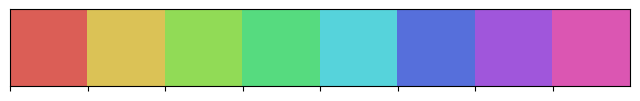

In [10]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

# Check emulator

In [11]:
emul = SimpleAtmEmulator()

emul.WL

In [12]:
WL = emul.GetWL()

## Check emulator with Rayleigh scattering

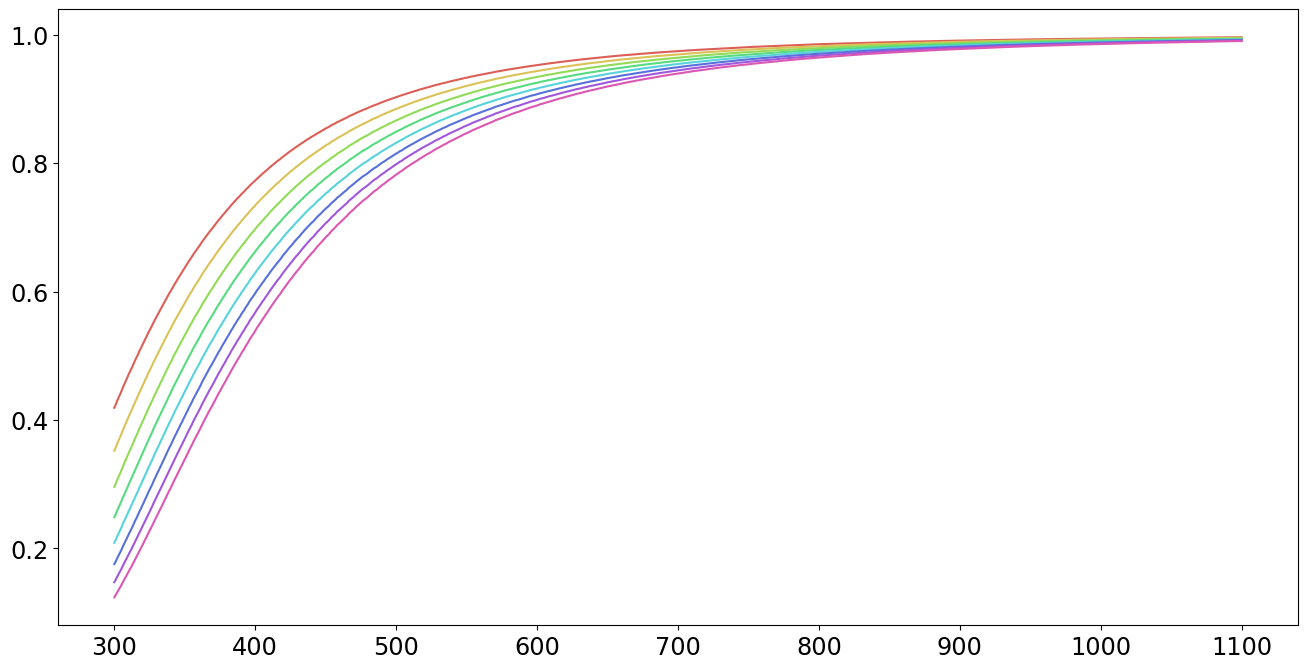

In [13]:
for idx,am in enumerate(airmasses):

    transm = emul.GetRayleighTransparencyArray(WL,am)
    plt.plot(WL,transm,color=hls_colors[idx])

In [14]:
if FLAG_CHECKWITHLIBRADTRAN:
    path,thefile = libsimulateVisible.ProcessSimulation(am0,pwv0,oz0,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
    data1 = np.loadtxt(os.path.join(path,thefile))
    path,thefile = libsimulateVisible.ProcessSimulation(am1,pwv1,oz1,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
    data2 = np.loadtxt(os.path.join(path,thefile))

In [15]:
if FLAG_CHECKWITHLIBRADTRAN:
    plt.figure(figsize=(14,8))
    plt.plot(WL,transm1,'b-',label=label0)
    plt.plot(data1[:,0],data1[:,1],'k:',label="librandtran")
    plt.plot(WL,transm2,'r-',label=label1)
    plt.plot(data2[:,0],data2[:,1],'k-.',label="libradtran")
    plt.legend()

## Check with aerosols

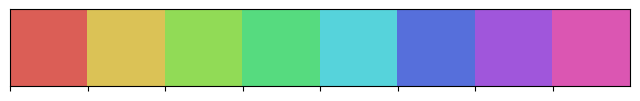

In [16]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

(0.0, 1.1)

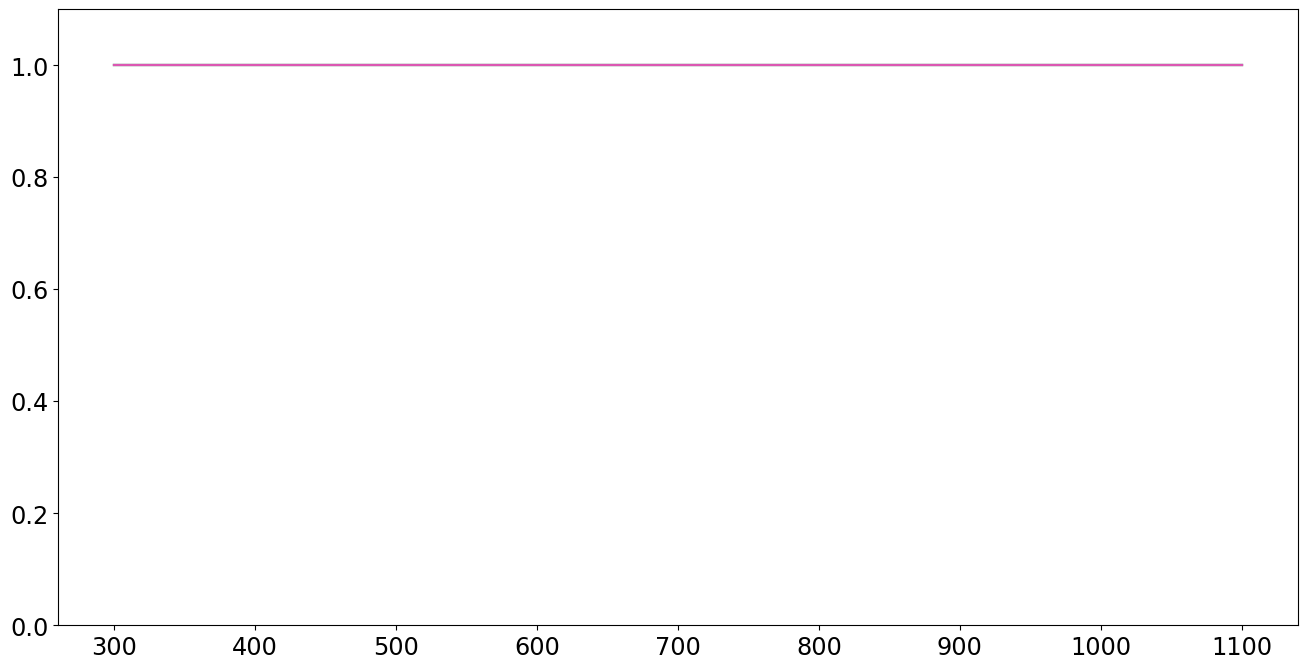

In [17]:
ncomp=0

for idx,am in enumerate(airmasses):

    transm = emul.GetAerosolsTransparencies(WL,am,ncomp)
    plt.plot(WL,transm,color=hls_colors[idx])
    
plt.ylim(0,1.1)

(0.0, 1.0)

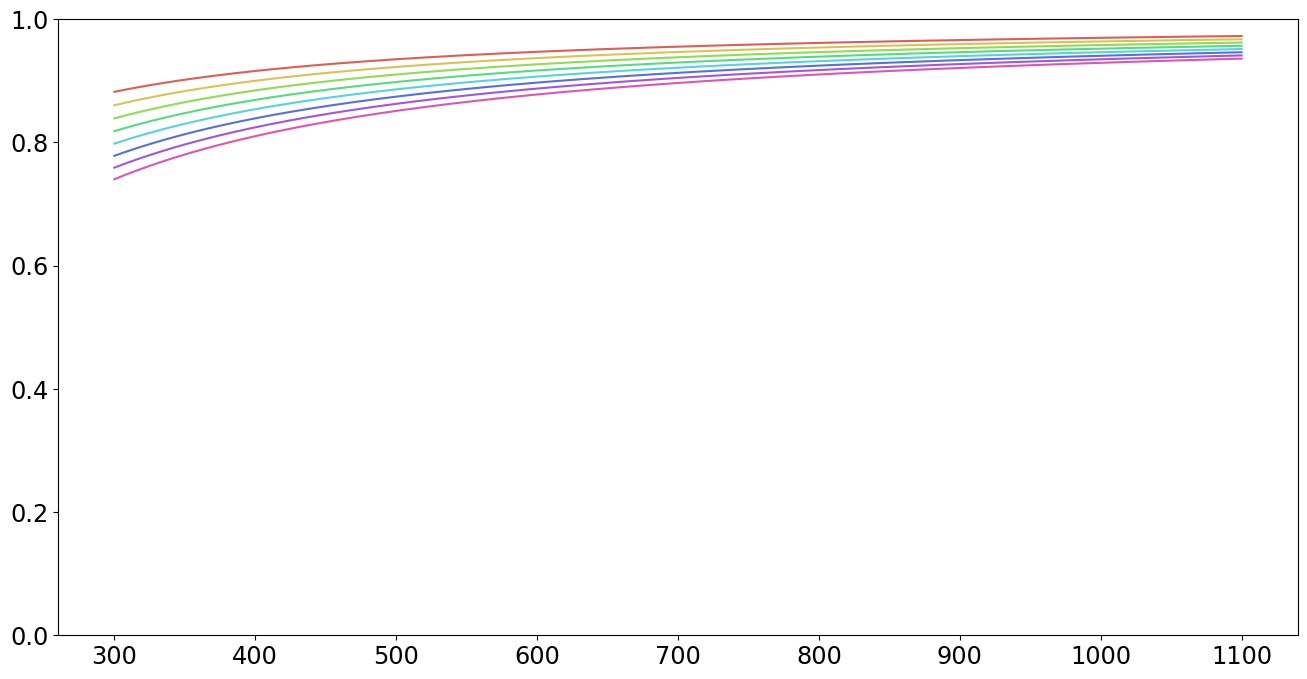

In [18]:
taus = [0.05, 0.01]
betas = [- 1.0, -2]
ncomp=2

for idx,am in enumerate(airmasses):

    transm = emul.GetAerosolsTransparencies(WL,am,ncomp,taus,betas)
    plt.plot(WL,transm,color=hls_colors[idx])
    
plt.ylim(0,1)

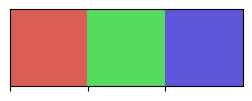

In [19]:
all_taus = [0.01, 0.05, 0.1]
betas = [- 1.0]
ncomp=1
am=1

NTAUS = len(all_taus)

hls_colors = sns.color_palette("hls", NTAUS)
sns.palplot(hls_colors)

(0.0, 1.0)

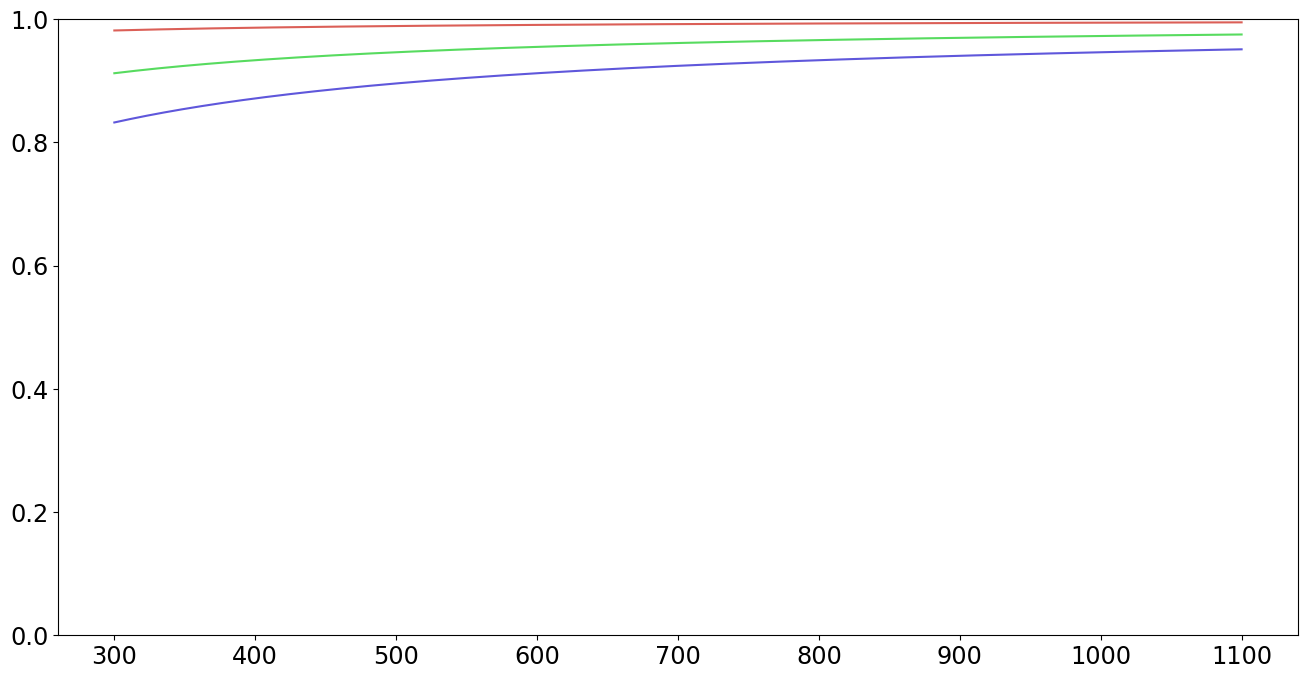

In [20]:
for idx,tau in enumerate(all_taus):
    taus = [tau]
    transm = emul.GetAerosolsTransparencies(WL,am,ncomp,taus,betas)
    plt.plot(WL,transm,color=hls_colors[idx])
    
plt.ylim(0,1)

## Test all combined transmission

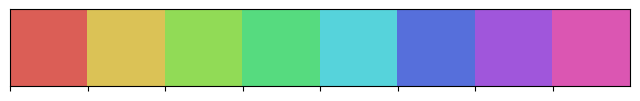

In [21]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

### Without aerosols

(0.0, 1.0)

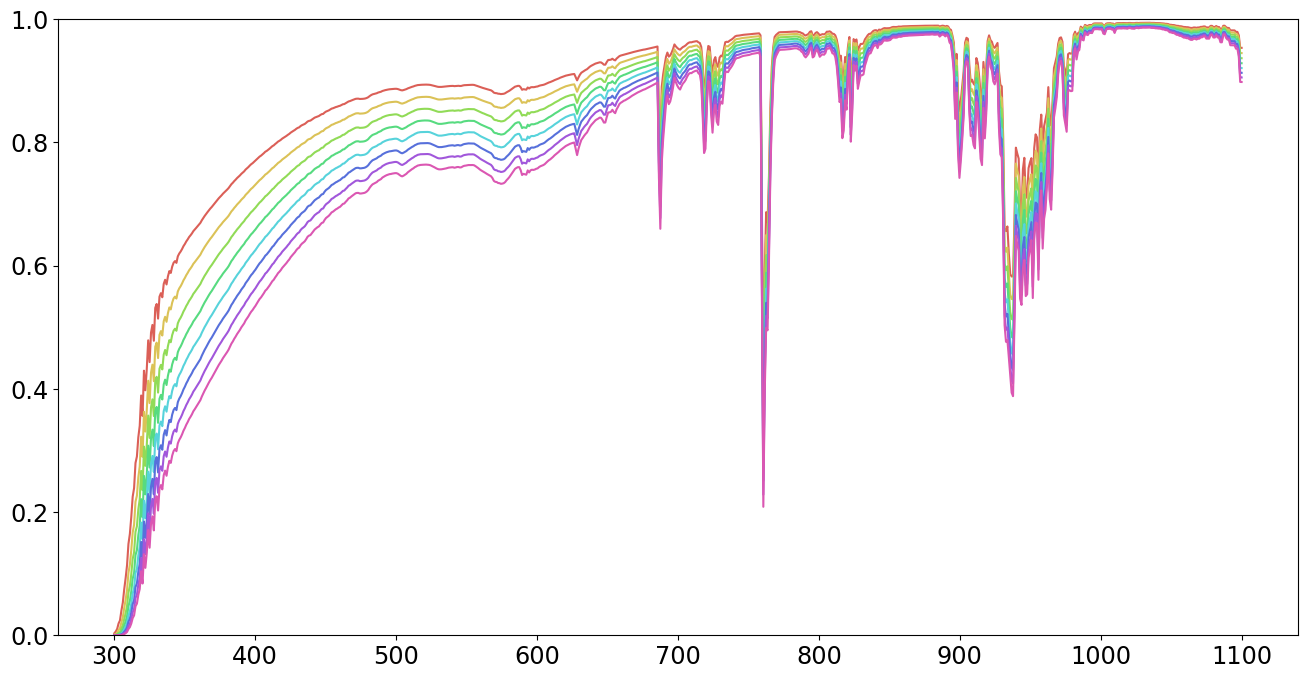

In [22]:
pwv0 = 5.0
oz0 = 500.

for idx,am in enumerate(airmasses):

    transm = emul.GetAllTransparencies(WL,am,pwv0,oz0)
    plt.plot(WL,transm,color=hls_colors[idx])
    
plt.ylim(0,1)

### With aerosols

(0.0, 1.0)

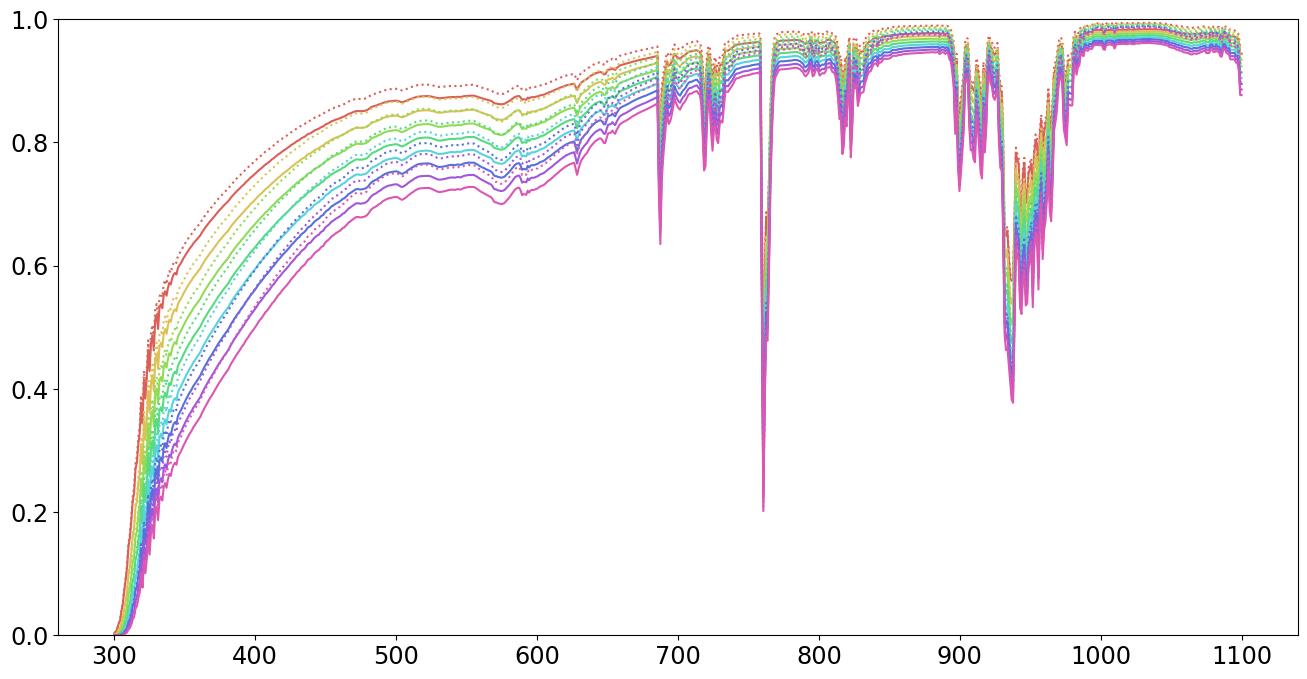

In [23]:
wv0 = 5.0
oz0 = 500.
ncomp=1
taus= [0.02]
betas = [-1]

for idx,am in enumerate(airmasses):

    transm = emul.GetAllTransparencies(WL,am,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
    transmnoaer = emul.GetAllTransparencies(WL,am,pwv0,oz0)
    plt.plot(WL,transm,color=hls_colors[idx])
    plt.plot(WL,transmnoaer,":",color=hls_colors[idx])
    
plt.ylim(0,1)

In [24]:
from pyExtinction.AtmosphericExtinction import ExtinctionModel

In [25]:
model = ExtinctionModel(WL*10.)

In [26]:
pars = np.array([750.,300.,550.,1.3])

In [27]:
model.setParams(pars, dpars=None)

<Axes: title={'center': 'SNfactory atmospheric extinction (Buton et al., 2013A&A...549A...8B)'}, xlabel='Wavelength [Å]', ylabel='Extinction [mag/airmass]'>

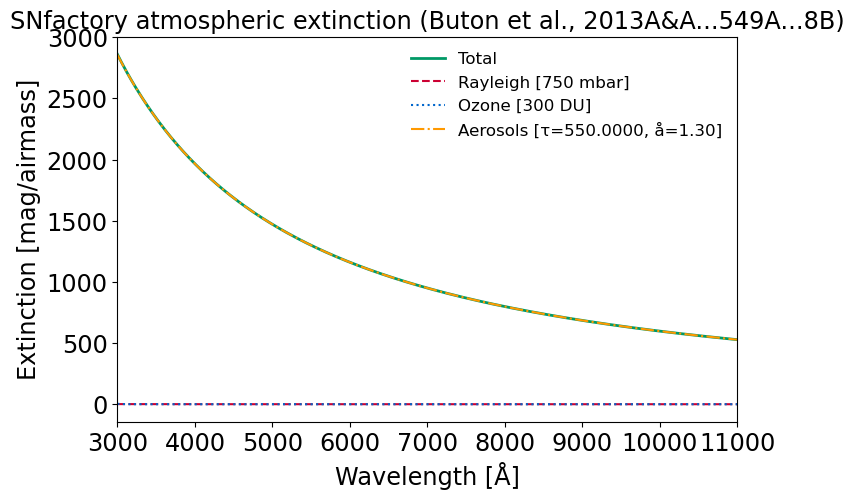

In [28]:
model.plot()

In [31]:
WL.min()

300.0

In [32]:
WL.max()

1100.0